# Conditional Indepence

In this notebook I will explain the process of building a Bayesian network from conditional independence. Bayesian networks are very powerfull and very used in the industry. The problem is that this are very expensive to build since they are super exponential, at least in the example that pertains to this notebook.

First of all we need to identify the libraries we need and import them. This are all needed in orther get a complety view of the results, check the report for help in installing pygraphviz.


*   Pomegranate
*   Networkx
*   Pygraphviz
*   Sklearn
*   Numpy
*   matplotlib
*   seaborn
*   itertools






In [1]:
#Bayesian Networks
import pomegranate
from pomegranate import BayesianNetwork
from pomegranate import *
#Utils
import seaborn, time
import numpy as np
import matplotlib.pyplot as plt
import copy
#Data
from sklearn.datasets import load_digits
from sklearn.datasets import load_breast_cancer
#Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression
from sklearn.feature_selection import chi2
#Accuracy
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
#Itertools
from itertools import combinations_with_replacement
from itertools import combinations
from itertools import permutations


seaborn.set_style('whitegrid')

# Data

For this particular example i decided to use the breast cancer data from sklearn, since is the one that is easier to interpret. In order to make this a quick example we will set the number of features we take to 4 as the standerd.

In [2]:
data= load_breast_cancer()
cancer_data, target = load_breast_cancer(return_X_y = True)
numVar = 4


print("Data shape: ",cancer_data.shape)
print("Class target shape: ",target.shape)
data["DESCR"]

Data shape:  (569, 30)
Class target shape:  (569,)


'.. _breast_cancer_dataset:\n\nBreast cancer wisconsin (diagnostic) dataset\n--------------------------------------------\n\n**Data Set Characteristics:**\n\n    :Number of Instances: 569\n\n    :Number of Attributes: 30 numeric, predictive attributes and the class\n\n    :Attribute Information:\n        - radius (mean of distances from center to points on the perimeter)\n        - texture (standard deviation of gray-scale values)\n        - perimeter\n        - area\n        - smoothness (local variation in radius lengths)\n        - compactness (perimeter^2 / area - 1.0)\n        - concavity (severity of concave portions of the contour)\n        - concave points (number of concave portions of the contour)\n        - symmetry\n        - fractal dimension ("coastline approximation" - 1)\n\n        The mean, standard error, and "worst" or largest (mean of the three\n        worst/largest values) of these features were computed for each image,\n        resulting in 30 features.  For inst

# Preprocessing

Our data is compossed of discrete numerical values, wich as i explained in the documentation is a 'no go' for any probabilistic aproach. In order to go around this we will change the values in the following way. For each feature we will calculate the mean and for every particular instance of that feature we will give it a true or false value based on if its value is higher or lower than the mean. Difference being that in this case we need it to explictly the True and False value from python in order to have a common value amongst all libraries. Since the class is already binary the only modification we will make to it is a reshape in order to match the cancer_data shape. In the future we will need to convine them so this is important.

In [3]:
for i in range( cancer_data.shape[1]):
    m = np.mean(cancer_data[:,i])
    for j in range(cancer_data.shape[0]):
        if cancer_data[j][i] > m:
            cancer_data[j][i] = True
        else:
            cancer_data[j][i] = False
            
target = np.reshape(target,(target.shape[0],1))
print("Class target shape: ",target.shape)
cancer_data

Class target shape:  (569, 1)


array([[1., 0., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 1., 0., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       ...,
       [1., 1., 1., ..., 1., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [0., 1., 0., ..., 0., 0., 0.]])

## Feature Selection

This networks are crazy time consuming scaling super-exponetially when we increse the numver of variables or the numver of values one takes, so doing good feature selection is important. In order to do this we need to use our feature selection algorithm after we make the conversion to True/False values. In this case i am using the SelectKBest algorithm from sklearn with chi2, others have shown similar results.

In [4]:
fSelector = SelectKBest(chi2, k= numVar)
selected_data = fSelector.fit_transform(cancer_data,target)
print("Feature selected data shape: ",selected_data.shape)

Feature selected data shape:  (569, 4)


## Splitting Our Dataset

we are almost at the end of the preprocessing part. In order to traint and test our data we will need to split it in 2.

In [5]:
# We use even indices for train data
cancer_train_data = selected_data [0::2]
cancer_train_class = target[0::2]

# We use odd could indices for test data
cancer_test_data  = selected_data[1::2]
cancer_test_class = target[1::2]

cancer_train_data.shape

(285, 4)

# Working With Features

Now that our data has been stadarized we need to start looking at our features and their distributions. For each feature we will count how many time it takes the value True, divide it between the number of samples and to get the chance of it being False we will just do P(F) = 1 - P(T)

In [6]:
trues =  []
cont = 0
for i in range(cancer_train_data.shape[1]):

    cont = 0
    for j in range(cancer_train_data.shape[0]):

        if cancer_train_data[j][i]:
            cont += 1

    trues.append(cont/cancer_train_data.shape[0])
trues

[0.3929824561403509,
 0.36140350877192984,
 0.3684210526315789,
 0.312280701754386]

Now we need to put this in a structure pomegranate will understand, we will use the DiscreteDistribution for our porpouses.

In [7]:
feature0 = DiscreteDistribution( {True: trues[0], False: 1-trues[0] } )
feature1 = DiscreteDistribution( {True: trues[1], False: 1-trues[1] } )
feature2 = DiscreteDistribution( {True: trues[2], False: 1-trues[2] } )
feature3 = DiscreteDistribution( {True: trues[3], False: 1-trues[3] } )

feature0

{
    "class" :"Distribution",
    "dtype" :"bool",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "True" :0.3929824561403509,
            "False" :0.6070175438596491
        }
    ],
    "frozen" :false
}

## Conditional Probability Table

The next step is to build a conditional probability table. Will will need to get a sample data where we have all the possible values the dataset can take and for each set of values two rows, one with the class at True with the chance of it being True and the same for the class at False. Here you can get a glance at why this scales in sucha a manner.

### Combination of values

we will use itertools to get an array where we store the posiblle combinations for the number of variables we have.

In [8]:
TRUEFALSE = [True,False]

comb = list(combinations_with_replacement(TRUEFALSE,numVar))
comb

[(True, True, True, True),
 (True, True, True, False),
 (True, True, False, False),
 (True, False, False, False),
 (False, False, False, False)]

### Permutations

Now that we have the combinations we will get for each one all the possible permutations and we will store them in an list. Once again we will use itertools.

In [9]:
perms = []

for i in comb:
    v = list(permutations(i))
    for j in v:
        if list(j) not in perms:
            perms.append(list(j))

print(np.shape(perms))
perms

(16, 4)


[[True, True, True, True],
 [True, True, True, False],
 [True, True, False, True],
 [True, False, True, True],
 [False, True, True, True],
 [True, True, False, False],
 [True, False, True, False],
 [True, False, False, True],
 [False, True, True, False],
 [False, True, False, True],
 [False, False, True, True],
 [True, False, False, False],
 [False, True, False, False],
 [False, False, True, False],
 [False, False, False, True],
 [False, False, False, False]]

### Completing the table

With the list above we are ready to complety our table. Lets combine the traing data with the training classes. Lets get every row from our list and we will search the dataset for every instance where the features have the same value. When this happens we store that case in a different list. after scanning the dataset for a particular value we will go the list where we stored them and start counting instances where the class is True. This is where the conditional probability table is built. We get the probabilty of the class being True and False for that set of values and we append twoo rows, one for the posibtive class and one for the negative.

In [10]:
final_train_data = np.concatenate((cancer_train_data,cancer_train_class), axis=1)
FINALTABLE = []
probs = []

#For every set of values we store the row from the dataset in probs
for i in perms:

    for j in final_train_data:
            aux = j[:numVar]
            #print(aux[0])
            if aux[0] == i[0] and aux[1] == i[1] and aux[2] == i[2] and aux[3] == i[3]:
                probs.append(j)

    #For every row in probs we compute the chance of it having True as a class
    cont = 0
    for k in probs:
        if k[4]:
            cont += 1
    #We add to our Table two rows one with the positive class and its chance and once for the negative class
    #with the reverse probability
    negation = copy.copy(i)
    i.append(1)
    negation.append(0)
    i.append(cont/cancer_train_data.shape[0])
    negation.append(1-(cont/cancer_train_data.shape[0]))
    FINALTABLE.append(i)
    FINALTABLE.append(negation)

np.shape(FINALTABLE)

(32, 6)

### Creating the distribution for pomegranate

The same way we needed to put the feature distribution in a way pomegrante understands we will do the same with our table. We need to pass the table we computed and the set of feautres affecting its values. The number of columns our table has will alway be: numFeatures +2, and the number of rows: allPosibleCombinations * 2

In [11]:
cancer_distribution = ConditionalProbabilityTable(FINALTABLE, [feature0,feature1,feature2,feature3])

### Building the Graph

This graph is a simple one where all the variables have direct influence in the class.

In [12]:
#Create a state for each feature and one for the table
s0 = State(feature0, name= "feature0")
s1 = State(feature1, name= "feature1")
s2 = State(feature2, name= "feature2")
s3 = State(feature3, name= "feature3")
s4 = State(cancer_distribution, name = "distribution")

#Add the estate to the network
bNetwork = BayesianNetwork("Conditional indepence")
bNetwork.add_states( s0, s1, s2, s3, s4 )

#Add the edges
bNetwork.add_edge(s0,s4)
bNetwork.add_edge(s1,s4)
bNetwork.add_edge(s2,s4)
bNetwork.add_edge(s3,s4)

### Baking the network

Baking the networks allows pomegrante to finnish learning the details in the conditional distributions of our table and the features. It is really finicky with the set of values, as in 1 wont at all correlate to True or even to 1.0 this is why I decided to go for Python True/Flase since this can be made universal accross libraries. Strings are an option but you encounter problems with how numpy will return to you those values and you table in the baking proccess so be carefull.

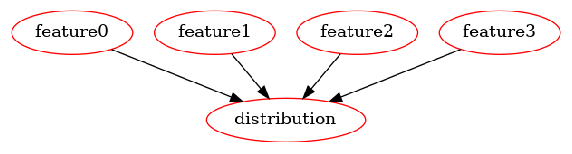

In [13]:
bNetwork.bake()

plt.figure(figsize=(10, 5))
bNetwork.plot()
plt.show()

## Predictions

we can get two type of predictions, one is the similiar to one we saw in the score based network and the other will give us a probability distribution.

In [14]:
print(bNetwork.predict_proba( [ { "feature0": True, "feature1": True, "feature2": True, "feature3": False } ] ) )


[array([True, True, True, False,
       {
    "class" :"Distribution",
    "dtype" :"int",
    "name" :"DiscreteDistribution",
    "parameters" :[
        {
            "0" :0.9929824561403506,
            "1" :0.0070175438596493354
        }
    ],
    "frozen" :false
}], dtype=object)]


In [15]:
#Once again we need to add the missing values for our network to predict
apendix = []
for i in range(cancer_test_class.shape[0]):
    apendix.append(None)
apendix = np.array(apendix).reshape(cancer_test_class.shape[0],1)

test = np.concatenate((cancer_test_data,apendix), axis=1)
res = bNetwork.predict( test )
res

[array([1.0, 1.0, 1.0, 1.0, 0], dtype=object),
 array([1.0, 0.0, 0.0, 0.0, 0], dtype=object),
 array([1.0, 0.0, 0.0, 0.0, 0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0], dtype=object),
 array([1.0, 0.0, 0.0, 0.0, 0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0], dtype=object),
 array([1.0, 1.0, 1.0, 0.0, 0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0], dtype=object),
 array([0.0, 0.0, 0.0, 0.0, 1], dtype=object),
 array([0.0, 0.0, 0.0, 0.0, 1], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0], dtype=object),
 array([1.0, 1.0, 1.0, 1.0, 0], dtype=object),
 array([0.0, 0.0, 0.0, 0.0, 1], dtype=object),
 array([1.0, 0.0, 1.0, 0.0, 0], dtype=object),
 array([1.0, 0.0, 0.0, 0.0, 0], dtype=object),
 array([1.0, 

# Validation

We will again validate our network the same way as before we will stract the class value from the object structure and use the accuary score and the confusion matrix to se the results.

In [16]:
#Extract the classes
predict = []
k = np.shape(res)
for i in range(k[0]):
    predict.append(res[i][numVar])
predict = np.array(predict).reshape(k[0],1)

In [17]:
acc = accuracy_score(predict, cancer_test_class)

confusionMTRX = confusion_matrix(cancer_test_class,predict)
print("Accuary score:",acc)
print("Confusion Matrix")
print(confusionMTRX)

Accuary score: 0.8943661971830986
Confusion Matrix
[[107   3]
 [ 27 147]]


We can see again very little differency in the accuracy but a very important change in the matrix, we are barely ever missclasifying the malign tumors, this is the reason I think this is the system that works best for the breast cancer dataset.